## Проект анализа результатов A/B теста

**Контекст задачи**:

Магазин недавно провёл А/B-тест, чтобы проверить новую платёжную воронку: гипотеза заключалась в том, что **новая платёжная воронка увеличит конверсию в покупку**.

**Цель**: проверка результатов A/B теста интернет-магазина.

**Содержание:**
1. Загрузка и подготовка данных
2. Исследовательский анализ данных теста
3. Проверка статистической значимости изменений


## 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

# Создадим датафреймы
new_users = pd.read_csv('sample_1.csv')
sessions = pd.read_csv('sample_2.csv')
purchases = pd.read_csv('sample_3.csv')
participants = pd.read_csv('sample_4.csv')

In [2]:
# Используем функцию для обзора данных:
def review(df, df_name):
    print(f'{"-"*50}')
    print(f'ОБЗОР ДАННЫХ: {df_name}')
    print(f'{"-"*50}')
    print(f'\nКОЛИЧЕСТВО СТРОК: {len(df)}')
    print('\nПЕРВЫЕ 5 СТРОК:')
    print(df.head())
    print('\nИНФОРМАЦИЯ О ДАННЫХ:')
    print(df.info())
    print('\nКОЛИЧЕСТВО ПРОПУСКОВ:')
    missing_count = df.isna().sum()
    if missing_count.sum() != 0:
        print(missing_count[missing_count>0])
    else:
        print('Пропусков нет')
    print('\nПРОЦЕНТ ПРОПУСКОВ:')
    missing_percent = round((df.isna().mean() * 100), 2)
    if missing_percent.sum() != 0:
        print(missing_percent[missing_percent > 0])
    else:
        print('0%')
    print('\nРАСПРЕДЕЛЕНИЕ ДАННЫХ:')
    print(df.describe())
    print('\nУНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ СТОЛБЦОВ:')
    has_cat_cols = False
    for column in list(df.columns):
        if (df[column].dtypes == 'object' or df[column].dtypes == 'category') and df[column].nunique() <= 15:
            has_cat_cols = True
            print(f'{column}:')
            print(df[column].unique())
    if not has_cat_cols:
        print('Категориальные столбцы не найдены или все имеют более 15 уникальных значений')
    print('\nКОЛИЧЕСТВО ЯВНЫХ ДУБЛИКАТОВ:')
    duplicates = df.duplicated().sum()
    print(duplicates if duplicates != 0 else 0)


In [3]:
# Вызовем функцию
dataframes = [new_users, sessions, purchases, participants]
names = ['new_users', 'sessions', 'purchases', 'participants']

for i, current_df in enumerate(dataframes):
    review(current_df, names[i])

--------------------------------------------------
ОБЗОР ДАННЫХ: new_users
--------------------------------------------------

КОЛИЧЕСТВО СТРОК: 131486

ПЕРВЫЕ 5 СТРОК:
            user_id  first_date          region   device
0  D72A72121175D8BE  2025-06-01      South Asia   iPhone
1  F1C668619DFE6E65  2025-06-01  Southeast Asia   iPhone
2  2E1BF1D4C37EA01F  2025-06-01    Central Asia      Mac
3  50734A22C0C63768  2025-06-01    Central Asia  Android
4  E1BDDCE0DAFA2679  2025-06-01  Southeast Asia   iPhone

ИНФОРМАЦИЯ О ДАННЫХ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131486 entries, 0 to 131485
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     131486 non-null  object
 1   first_date  131486 non-null  object
 2   region      131486 non-null  object
 3   device      131486 non-null  object
dtypes: object(4)
memory usage: 4.0+ MB
None

КОЛИЧЕСТВО ПРОПУСКОВ:
Пропусков нет

ПРОЦЕНТ ПРОПУСКОВ:
0%

РАСПР

In [4]:
# Приведем столбцы к корректным типам данных
new_users['first_date'] = pd.to_datetime(new_users['first_date'])
sessions['session_start'] = pd.to_datetime(sessions['session_start']).dt.date
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])

In [5]:
# Найдем участников теста
test_np = participants[participants.ab_test == 'new_payment_funnel_test_summer_2025']

# Найдем пользователей групп
a_users = test_np[test_np.group == 'A']['user_id']
b_users = test_np[test_np.group == 'B']['user_id']

# Найдем пересечения
intersection = list(set(a_users) & set(b_users))
intersection


[]

Пересечений **нет**.

Количество пользователей в группе A: 1598
Количество пользователей в группе B: 1468


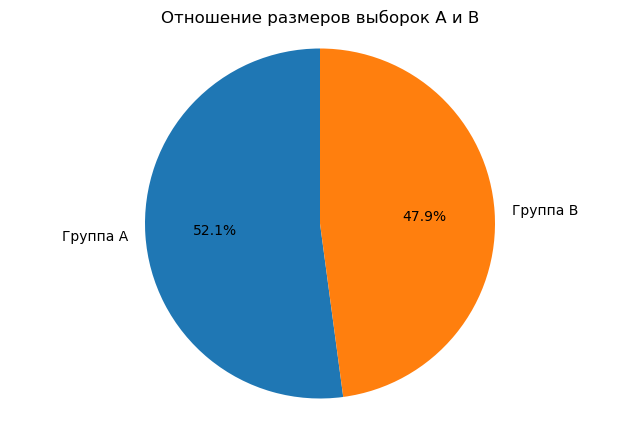

In [6]:
# Проверим соотношение пользователей в выборках
print(f'Количество пользователей в группе A: {a_users.count()}')
print(f'Количество пользователей в группе B: {b_users.count()}')


# Построим круговую диаграмму с размерами групп
# Данные для диаграммы
sizes = [a_users.count(), b_users.count()]
labels = ['Группа A', 'Группа B']

# Построение диаграммы
plt.figure(figsize=(8, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Отношение размеров выборок A и B')
plt.show()


Разница в количестве пользователей **незначительна**.

In [7]:
# Оставим данные только по участникам теста
tested_purchase = pd.merge(test_np, purchases, on='user_id')
tested_sessions = pd.merge(test_np, sessions, on='user_id')
tested_new_users = pd.merge(test_np, new_users, on='user_id')

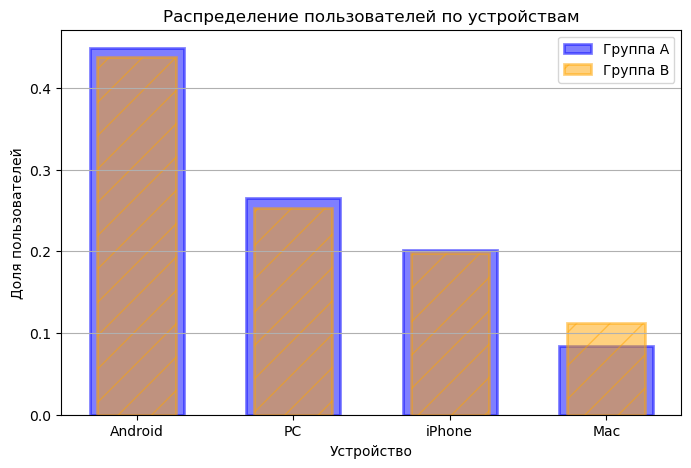

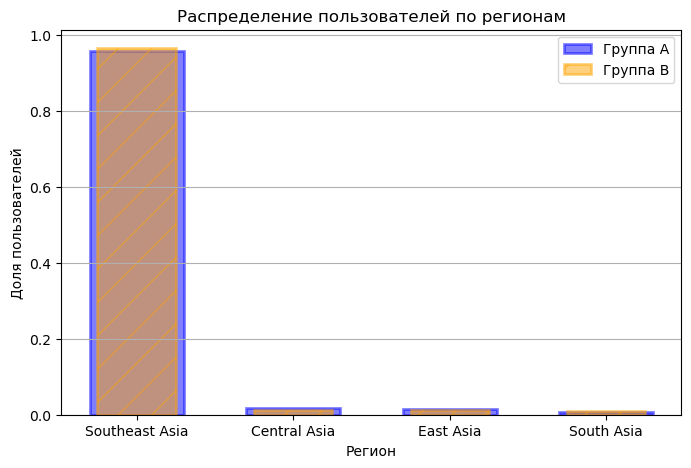

In [8]:
# Проверим сопоставимость выборок по устройствам и регионам
def check_func(col, name, name_2):
    dev_a = tested_new_users[tested_new_users.group == 'A'].groupby(['group', col])['user_id'].nunique()
    dev_b = tested_new_users[tested_new_users.group == 'B'].groupby(['group', col])['user_id'].nunique()
    # Расчитаем доли
    dev_a_share = dev_a/dev_a.sum()
    dev_a_share = dev_a_share.reset_index().sort_values(by='user_id', ascending=False)
    dev_b_share = dev_b/dev_b.sum()
    dev_b_share = dev_b_share.reset_index().sort_values(by='user_id',ascending=False)

    # Построим график распределения пользователей по устройствам
    plt.figure(figsize = (8,5))
    plt.bar(col, 'user_id', data=dev_a_share, label='Группа A', alpha=0.5, color='blue', edgecolor='blue', linewidth=2, width=0.6)
    plt.bar(col, 'user_id', data=dev_b_share, label='Группа B', alpha=0.5, color='orange', edgecolor='orange', linewidth=2, width=0.5, hatch='/')
    plt.title(f'Распределение пользователей по {name}')
    plt.legend()
    plt.xlabel(f'{name_2}')
    plt.ylabel('Доля пользователей')
    plt.xticks()
    plt.grid(axis='y')
    plt.show()

check_func('device', 'устройствам', 'Устройство')
check_func('region', 'регионам', 'Регион')

Можно увидеть значительное различие в доле пользователей с Mac. В группе B такая доля **выше**. Распределение по регионам **более сопоставимо**. Лидириет Юго-Восточная Азия.

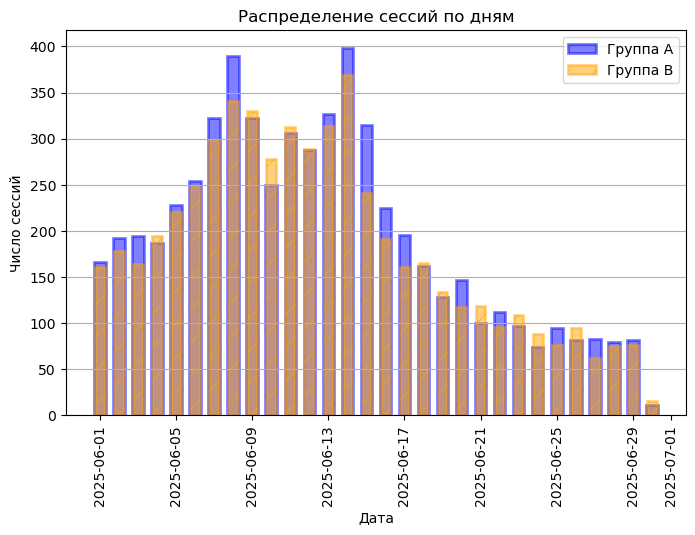

In [9]:
# Сгруппируем данные по дню сессии и тестовой группе
ses_group = tested_sessions.groupby(['group','session_start'])['user_id'].count().reset_index()

# Сформируем два датафрейма по группам
ses_group_a = ses_group[ses_group.group == 'A']
ses_group_b = ses_group[ses_group.group == 'B']

# Построим столбчатую диаграмму с распределением значений по дням
plt.figure(figsize = (8,5))
plt.bar('session_start', 'user_id', data=ses_group_a, label='Группа A', alpha=0.5, color='blue', edgecolor='blue', linewidth=2, width=0.6)
plt.bar('session_start', 'user_id', data=ses_group_b, label='Группа B', alpha=0.5, color='orange', edgecolor='orange', linewidth=2, width=0.5, hatch='/')
plt.title('Распределение сессий по дням')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Число сессий')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

В распределении сессий присутствует определенная разница, но в целом они похожи и достаточно **сопоставимы**.

## 2. Исследовательский анализ данных теста

In [10]:
# Рассчитаем конверсию для двух групп
m_a = tested_purchase[tested_purchase.group == 'A']['user_id'].nunique()
n_a = tested_new_users[tested_new_users.group == 'A']['user_id'].nunique()
m_b = tested_purchase[tested_purchase.group == 'B']['user_id'].nunique()
n_b = tested_new_users[tested_new_users.group == 'B']['user_id'].nunique()

p_a = m_a/n_a
p_b = m_b/n_b
abs_d = abs(p_a - p_b) * 100
print(f'Количество пользователей, сделавших покупку, в контрольной группе составляет {m_a}')
print(f'Общее количество пользователей в контрольной группе составляет {n_a}')
print()
print(f'Количество пользователей, сделавших покупку, в тестовой группе составляет {m_b}')
print(f'Общее количество пользователей в тестовой группе составляет {n_b}')
print()
print(f'Конверсия в покупку контрольной группы: {round(p_a,2)}')
print(f'Конверсия в покупку тестовой группы: {round(p_b,2)}')
print()
print(f'Разница между конверсиями в покупку составляет {round(abs_d, 1)} процентных пункта')

Количество покупок в контрольной группе составляет 472
Количество сессий в контрольной группе составляет 1598

Количество покупок в тестовой группе составляет 270
Количество сессий в тестовой группе составляет 1468

Конверсия в покупку контрольной группы: 0.3
Конверсия в покупку тестовой группы: 0.18

Разница между конверсиями в покупку составляет 11.1 процентных пункта


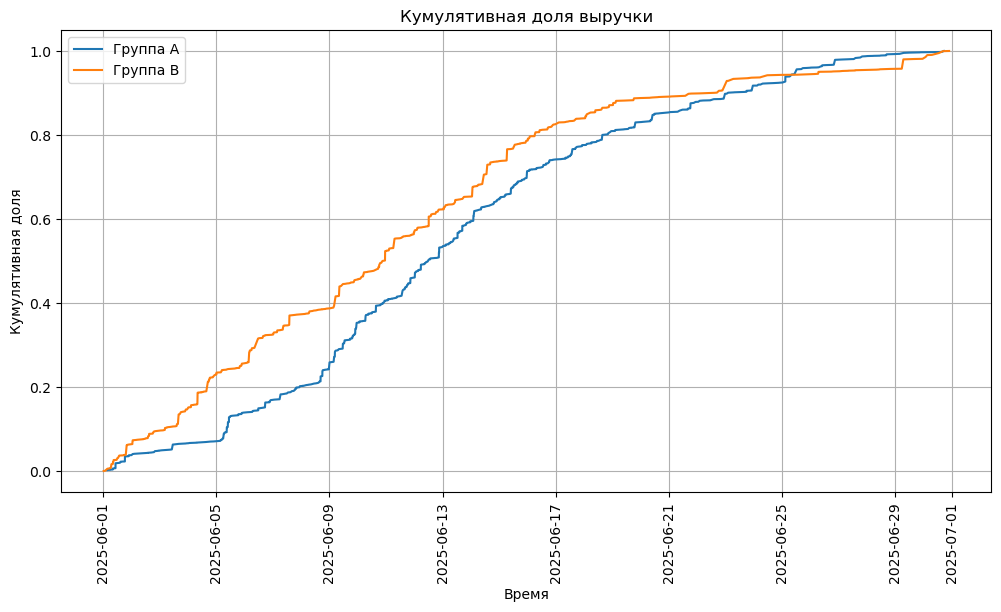

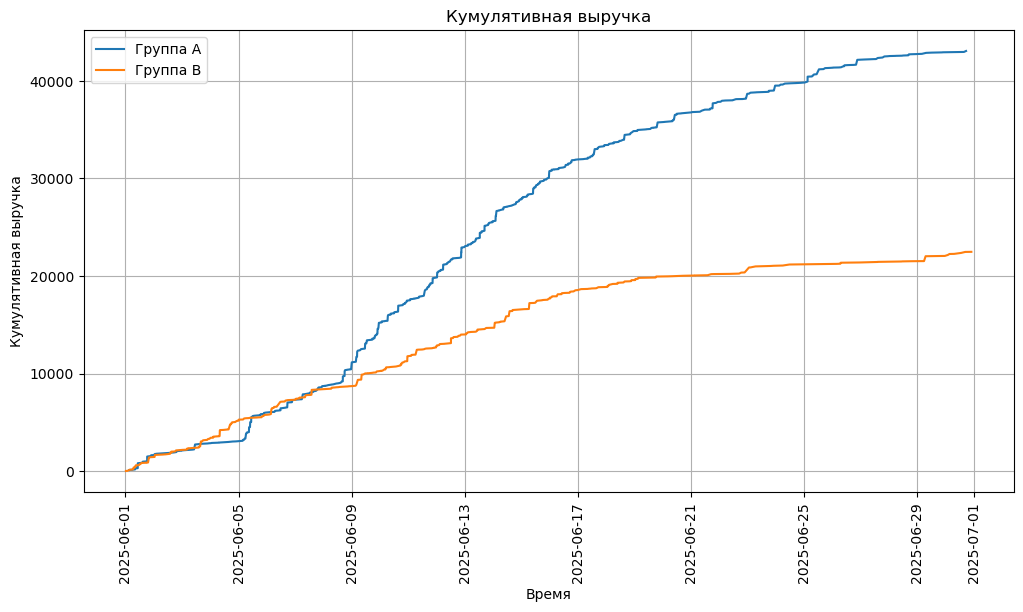

In [11]:
# Визуализируем кумулятивную динамику выручки
# Рассчитаем показатели контрольной группы
cum_tested_purchase_a = tested_purchase[tested_purchase.group == 'A'][['event_dt','revenue']].sort_values(by='event_dt').reset_index()
cum_tested_purchase_a['cum_revenue'] = cum_tested_purchase_a['revenue'].cumsum()
cum_tested_purchase_a['cum_share'] = cum_tested_purchase_a['cum_revenue'] / cum_tested_purchase_a['revenue'].sum()
# Рассчитаем показатели тестовой группы
cum_tested_purchase_b = tested_purchase[tested_purchase.group == 'B'][['event_dt','revenue']].sort_values(by='event_dt').reset_index()
cum_tested_purchase_b['cum_revenue'] = cum_tested_purchase_b['revenue'].cumsum()
cum_tested_purchase_b['cum_share'] = cum_tested_purchase_b['cum_revenue'] / cum_tested_purchase_b['revenue'].sum()

# Построим линейный график для группы A и группы B (доля)
plt.figure(figsize=(12, 6))
plt.plot(cum_tested_purchase_a['event_dt'], cum_tested_purchase_a['cum_share'], label='Группа A')
plt.plot(cum_tested_purchase_b['event_dt'], cum_tested_purchase_b['cum_share'], label='Группа B')
plt.title('Кумулятивная доля выручки')
plt.xlabel('Время')
plt.ylabel('Кумулятивная доля')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Визуализируем кумулятивную динамику выручки (абсолютные значения)
plt.figure(figsize=(12, 6))
plt.plot(cum_tested_purchase_a['event_dt'], cum_tested_purchase_a['cum_revenue'], label='Группа A')
plt.plot(cum_tested_purchase_b['event_dt'], cum_tested_purchase_b['cum_revenue'], label='Группа B')
plt.title('Кумулятивная выручка')
plt.xlabel('Время')
plt.ylabel('Кумулятивная выручка')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

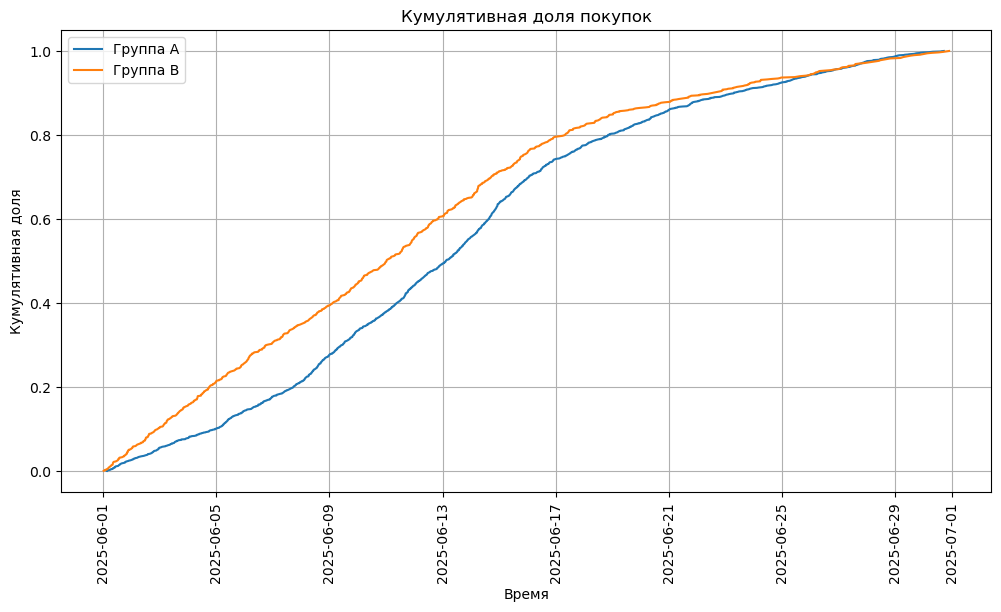

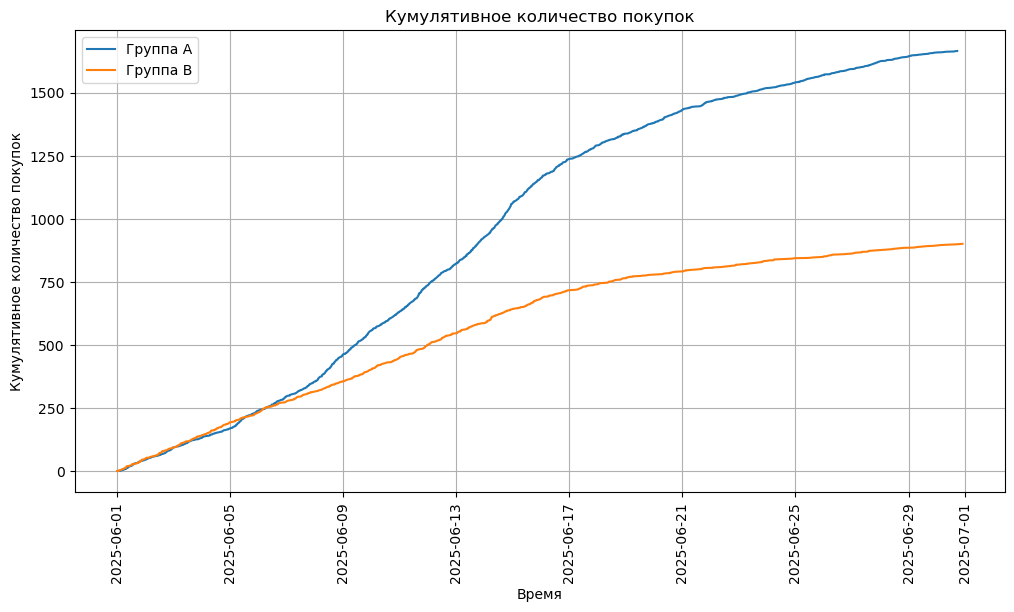

In [12]:
# Визуализируем кумулятивную динамику покупок
# Рассчитаем показатели контрольной группы
cum_tested_purchase_a = tested_purchase[tested_purchase.group == 'A'][['event_dt']].sort_values(by='event_dt').reset_index()
cum_tested_purchase_a['cum_purchases'] = range(1, len(cum_tested_purchase_a) + 1)
cum_tested_purchase_a['cum_share'] = cum_tested_purchase_a['cum_purchases'] / cum_tested_purchase_a['cum_purchases'].max()

# Рассчитаем показатели тестовой группы
cum_tested_purchase_b = tested_purchase[tested_purchase.group == 'B'][['event_dt']].sort_values(by='event_dt').reset_index()
cum_tested_purchase_b['cum_purchases'] = range(1, len(cum_tested_purchase_b) + 1)
cum_tested_purchase_b['cum_share'] = cum_tested_purchase_b['cum_purchases'] / cum_tested_purchase_b['cum_purchases'].max()

# Построим линейный график для группы A и группы B (доля)
plt.figure(figsize=(12, 6))
plt.plot(cum_tested_purchase_a['event_dt'], cum_tested_purchase_a['cum_share'], label='Группа A')
plt.plot(cum_tested_purchase_b['event_dt'], cum_tested_purchase_b['cum_share'], label='Группа B')
plt.title('Кумулятивная доля покупок')
plt.xlabel('Время')
plt.ylabel('Кумулятивная доля')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()

# Визуализируем кумулятивную динамику покупок (абсолютные значения)
plt.figure(figsize=(12, 6))
plt.plot(cum_tested_purchase_a['event_dt'], cum_tested_purchase_a['cum_purchases'], label='Группа A')
plt.plot(cum_tested_purchase_b['event_dt'], cum_tested_purchase_b['cum_purchases'], label='Группа B')
plt.title('Кумулятивное количество покупок')
plt.xlabel('Время')
plt.ylabel('Кумулятивное количество покупок')
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.show()


Диаграммы однозначно показывают, что в промежутке между 05.06.25 и 09.06.25 кумулятивные выручка и количество покупок **сильно разошлись**, причем тестовая группа начала показывать результаты **сильно ниже** контрольной. Из-за менее стремительного роста по абсолютным показателям группа B в диаграммах с долями растет быстрее.

Отдельно стоит отметить, что расхождение между группами отражается на графике достаточно **резко** и относительно **одномоментно**, что **вызывает сомнение в корректности** проведения теста. Возможно стоит дополнительно перепроверить **метод сбора данных и разделения пользователей** по группам.

## 3. Проверка статистической значимости изменений

In [13]:
# Проверим достаточность количества данных для z-теста пропорций:
if (p_a * n_a > 10) and ((1 - p_a) * n_a > 10) and (p_b * n_b > 10) and ((1 - p_b) * n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется')
else:
    print('Предпосылка о достаточном количестве данных не выполняется')

Предпосылка о достаточном количестве данных выполняется


In [14]:
# Проведем z-тест пропорций
alpha = .05

stat_zt, p_value_zt = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)
print(round(p_value_zt,4))
if p_value_zt < alpha:
    print('Нулевая гипотеза не находит подтверждения. Принимаем альтернативную гипотезу.')
else:
    print('Нулевая гипотеза находит подтверждение')

1.0
Нулевая гипотеза находит подтверждение


В данном случае статистический тест был даже **избыточен**, потому что значения тестовой группы явно **уменьшились** по сравнению с контрольной. Сформулируем дополнительную гипотезу о том, что эффект обратный и новая платежная воронка **ухудшает** конверсию в оплату. Проведем повторный тест.

In [15]:
# Проведем z-тест пропорций с обратной гипотезой
alpha = .05

stat_zt, p_value_zt = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='larger'
)
print(round(p_value_zt,4))
if p_value_zt < alpha:
    print('Нулевая гипотеза не находит подтверждения. Принимаем альтернативную гипотезу.')
else:
    print('Нулевая гипотеза находит подтверждение')

0.0
Нулевая гипотеза не находит подтверждения. Принимаем альтернативную гипотезу.


Как и ожидалось, тест выявил статистическую значимость **уменьшения конверсии в покупку** в тестовой группе.

## Вывод

1. При проверке распределения пользователей на группы, а также проверки распределения характеристик пользователей и их сессий значительных нарушений **найдено не было**. Распределения достаточно **равномерны**.
2. Наблюдается **резкое отличие** в кумулятивных значениях динамики покупок и выручки. При этом расхождение явное и происходит в конкретном временном промежутке. Возможно, требуется дополнительная проверка **корректности** сбора данных или наличием других аномалий.
3. Различие в целевых метриках двух групп **присутствует** и оно явное. Разница между конверсиями в покупку составляет **11.3** процентных пункта. Однако в значения в тестовой группе **ухудшились** по сравнению с контрольной и такое ухудшение статистически значимо. Внедрение нововведения **не рекомендуется.**